In [27]:
import pandas as pd
from collections import defaultdict
from obspy import UTCDateTime
import numpy as np
from bisect import bisect_left
from pathlib import Path
import torch
import obspy
import seaborn as sns

In [2]:
split_info=torch.load("/mnt/home/xiziyi/Packages_Research/PhaseNet-TF/workplace/split_pairs.pt")

In [3]:
split_info

{'train_pairs': [('1_52260', 'CICA'),
  ('22_52535', 'C02'),
  ('2_52228', 'S02W'),
  ('4_55311', 'B12'),
  ('2_52297', 'N03W'),
  ('4_55406', 'NMKA'),
  ('1_51965', 'A11'),
  ('11_52234', 'S02W'),
  ('11_52336', 'EUAP'),
  ('2_52151', 'B06'),
  ('3_52658', 'A08W'),
  ('4_55441', 'A03'),
  ('1_52158', 'A03'),
  ('1_52152', 'F02W'),
  ('3_52154', 'C15'),
  ('2_52329', 'TNGA'),
  ('22_52630', 'C02'),
  ('3_52492', 'A10W'),
  ('4_54752', 'PNGI'),
  ('4_54752', 'B06'),
  ('2_52421', 'FONI'),
  ('3_53818', 'NMKA'),
  ('3_53598', 'A01'),
  ('2_52599', 'TNGA'),
  ('1_51923', 'NADI'),
  ('1_51874', 'TNGA'),
  ('4_54579', 'NMKA'),
  ('1_51864', 'FOA'),
  ('4_54537', 'N02W'),
  ('2_52215', 'C13'),
  ('1_52249', 'MOAL'),
  ('4_55428', 'VAVP'),
  ('2_52245', 'B06'),
  ('4_55466', 'LKBA'),
  ('3_52343', 'PNGI'),
  ('4_54516', 'FOA'),
  ('2_52266', 'VAVP'),
  ('1_52225', 'A01'),
  ('1_51885', 'CICA'),
  ('2_52107', 'A05'),
  ('1_51958', 'A10W'),
  ('3_53719', 'B03'),
  ('1_51903', 'A14W'),
  ('3_524

In [4]:
old_path="/mnt/home/xiziyi/Packages_Research/PhaseNet-TF/dataset/phase_picks.csv"
old=pd.read_csv(old_path)
# map station_id to sta, phase_time to time, phase_type to phase
old=old.rename(columns={"station_id":"sta","phase_time":"time","phase_type":"phase"})

In [5]:
# if old's (event_id,sta) is in split_info["test_pairs"], then it's test set and write to old_test
old_test=old[old.apply(lambda x: (x["event_id"],x["sta"]) in split_info["test_pairs"],axis=1)]

In [6]:
new_paths=[f"/mnt/scratch/xiziyi/inference/new_20230509/train_bench_0_1/phase_arrivals_{i}.csv" for i in range(4)]
new_dfs=[pd.read_csv(new_path,skiprows=1,usecols=[0,1,4,5,6,7],names=["net","sta","phase","offset","time","score"]) for new_path in new_paths]
new=pd.concat(new_dfs)

In [7]:
len(old),len(new),len(old_test)

(60307, 202833, 3017)

In [8]:
def update_cache(cache, row):
    cache[row.sta][row.phase].append(UTCDateTime(row.time))

def sort_cache(cache):
    for sta in cache:
        for phase in cache[sta]:
            cache[sta][phase].sort()

old_cache = defaultdict(lambda: defaultdict(list))
new_cache = defaultdict(lambda: defaultdict(list))
old_test_cache = defaultdict(lambda: defaultdict(list))

old.apply(lambda row: update_cache(old_cache, row), axis=1)
new.apply(lambda row: update_cache(new_cache, row), axis=1)
old_test.apply(lambda row: update_cache(old_test_cache, row), axis=1)

sort_cache(old_cache)
sort_cache(new_cache)
sort_cache(old_test_cache)

In [9]:
def get_confusion_matrix(sta,phase,real,predict,threshold):
    # * now we use the binary search
    # for each real, search in predict
    tp,fn=0,0
    for each in real:
        pos=bisect_left(predict,each)
        case1=False
        if pos>0:
            case1=np.abs(predict[pos-1]-each)<=threshold
        case2=False
        if pos<len(predict):
            case2=np.abs(predict[pos]-each)<=threshold
        if case1 or case2:
            tp+=1
        else:
            fn+=1

    # for each predict, search in real
    tp_recalculate,fp=0,0
    for each in predict:
        pos=bisect_left(real,each)
        case1=False
        if pos>0:
            case1=np.abs(real[pos-1]-each)<=threshold
        case2=False
        if pos<len(real):
            case2=np.abs(real[pos]-each)<=threshold
        if case1 or case2:
            tp_recalculate+=1
        else:
            fp+=1
    try:
        assert tp==tp_recalculate
    except:
        print(f"{sta} {phase} {tp} {tp_recalculate}")
    return tp,fn,fp

In [10]:
threshold=2

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 168 167
A08W S 88 87
A09 S 150 149
A11 S 159 158


(defaultdict(int, {'P': 41043, 'S': 13863, 'PS': 0}),
 defaultdict(int, {'P': 206, 'S': 71, 'PS': 5124}),
 defaultdict(int, {'P': 87612, 'S': 60245, 'PS': 0}))

In [11]:
threshold=2

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2055, 'S': 690, 'PS': 0}),
 defaultdict(int, {'P': 8, 'S': 7, 'PS': 257}),
 defaultdict(int, {'P': 126493, 'S': 72561, 'PS': 0}))

In [12]:
threshold=1.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 168 167
A08W S 88 87
A09 S 150 149
A11 S 159 158


(defaultdict(int, {'P': 40995, 'S': 13857, 'PS': 0}),
 defaultdict(int, {'P': 254, 'S': 77, 'PS': 5124}),
 defaultdict(int, {'P': 87660, 'S': 60251, 'PS': 0}))

In [13]:
threshold=1.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2053, 'S': 690, 'PS': 0}),
 defaultdict(int, {'P': 10, 'S': 7, 'PS': 257}),
 defaultdict(int, {'P': 126495, 'S': 72561, 'PS': 0}))

In [14]:
threshold=1.0

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 168 167
A08W S 88 87
A09 S 150 149
A11 S 159 158


(defaultdict(int, {'P': 40888, 'S': 13847, 'PS': 0}),
 defaultdict(int, {'P': 361, 'S': 87, 'PS': 5124}),
 defaultdict(int, {'P': 87767, 'S': 60261, 'PS': 0}))

In [15]:
threshold=1.0

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2048, 'S': 690, 'PS': 0}),
 defaultdict(int, {'P': 15, 'S': 7, 'PS': 257}),
 defaultdict(int, {'P': 126500, 'S': 72561, 'PS': 0}))

In [16]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A08W S 86 85
A09 S 139 138
A11 S 152 151


(defaultdict(int, {'P': 40361, 'S': 13635, 'PS': 0}),
 defaultdict(int, {'P': 888, 'S': 299, 'PS': 5124}),
 defaultdict(int, {'P': 88294, 'S': 60472, 'PS': 0}))

In [17]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2013, 'S': 682, 'PS': 0}),
 defaultdict(int, {'P': 50, 'S': 15, 'PS': 257}),
 defaultdict(int, {'P': 126535, 'S': 72569, 'PS': 0}))

In [18]:
confusion_matrix_with_problems=[]
def get_confusion_matrix_with_problems(sta,phase,real,predict,threshold):
    # * now we use the binary search
    # for each real, search in predict
    tp,fn=0,0
    for each in real:
        pos=bisect_left(predict,each)
        case1=False
        if pos>0:
            case1=np.abs(predict[pos-1]-each)<=threshold
        case2=False
        if pos<len(predict):
            case2=np.abs(predict[pos]-each)<=threshold
        if case1 or case2:
            tp+=1
        else:
            fn+=1
            if phase=="S":
                confusion_matrix_with_problems.append((sta,each,predict[pos-1] if pos>0 else None,predict[pos] if pos<len(predict) else None))

    # for each predict, search in real
    tp_recalculate,fp=0,0
    for each in predict:
        pos=bisect_left(real,each)
        case1=False
        if pos>0:
            case1=np.abs(real[pos-1]-each)<=threshold
        case2=False
        if pos<len(real):
            case2=np.abs(real[pos]-each)<=threshold
        if case1 or case2:
            tp_recalculate+=1
        else:
            fp+=1
    try:
        assert tp==tp_recalculate
    except:
        print(f"{sta} {phase} {tp} {tp_recalculate}")
    return tp,fn,fp

In [19]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix_with_problems(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2013, 'S': 682, 'PS': 0}),
 defaultdict(int, {'P': 50, 'S': 15, 'PS': 257}),
 defaultdict(int, {'P': 126535, 'S': 72569, 'PS': 0}))

In [20]:
confusion_matrix_with_problems.sort()
confusion_matrix_with_problems

[('A01',
  2010-02-19T19:57:33.575900Z,
  2010-02-19T17:49:38.544000Z,
  2010-02-20T12:26:04.894000Z),
 ('A06W',
  2010-05-13T02:48:57.003470Z,
  2010-05-12T22:00:41.619800Z,
  2010-05-13T02:48:57.619800Z),
 ('A09',
  2010-01-02T21:55:09.862080Z,
  2010-01-02T00:13:13.622000Z,
  2010-01-02T21:55:10.502000Z),
 ('A09',
  2010-03-22T23:54:33.877570Z,
  2010-03-19T11:02:03.101000Z,
  2010-03-23T17:24:36.421000Z),
 ('A09',
  2010-04-04T00:22:12.086430Z,
  2010-04-03T18:59:11.498000Z,
  2010-04-04T00:56:02.698000Z),
 ('A09',
  2010-07-15T19:34:31.056840Z,
  2010-07-15T19:34:30.541000Z,
  2010-07-16T04:19:06.088000Z),
 ('A11',
  2010-02-08T14:38:33.725820Z,
  2010-02-08T14:38:33.026000Z,
  2010-02-08T14:39:51.716000Z),
 ('A14W',
  2010-03-04T13:03:15.237210Z,
  2010-03-04T13:03:14.324301Z,
  2010-03-04T21:19:33.204301Z),
 ('B01W',
  2010-01-13T10:59:02.593600Z,
  2010-01-13T10:54:34.028000Z,
  2010-01-14T17:51:40.618000Z),
 ('B02',
  2009-12-08T20:53:01.987684Z,
  2009-12-08T15:22:02.309000Z,

Now we can plot some distribution graph.

In [21]:
diffs_in_tp_P=[]
diffs_in_tp_S=[]
def get_confusion_matrix_with_diffs(sta,phase,real,predict,threshold):
    # * now we use the binary search
    # for each real, search in predict
    tp,fn=0,0
    for each in real:
        pos=bisect_left(predict,each)
        case1=False
        if pos>0:
            case1=np.abs(predict[pos-1]-each)<=threshold
        case2=False
        if pos<len(predict):
            case2=np.abs(predict[pos]-each)<=threshold
        if case1 or case2:
            tp+=1
            if phase=="P":
                diff1=np.abs(predict[pos-1]-each) if pos>0 else 999999
                diff2=np.abs(predict[pos]-each) if pos<len(predict) else 999999
                if diff1<diff2:
                    diffs_in_tp_P.append(predict[pos-1]-each)
                else:
                    diffs_in_tp_P.append(predict[pos]-each)
            elif phase=="S":
                diff1=np.abs(predict[pos-1]-each) if pos>0 else 999999
                diff2=np.abs(predict[pos]-each) if pos<len(predict) else 999999
                if diff1<diff2:
                    diffs_in_tp_S.append(predict[pos-1]-each)
                else:
                    diffs_in_tp_S.append(predict[pos]-each)
        else:
            fn+=1

    # for each predict, search in real
    tp_recalculate,fp=0,0
    for each in predict:
        pos=bisect_left(real,each)
        case1=False
        if pos>0:
            case1=np.abs(real[pos-1]-each)<=threshold
        case2=False
        if pos<len(real):
            case2=np.abs(real[pos]-each)<=threshold
        if case1 or case2:
            tp_recalculate+=1
        else:
            fp+=1
    try:
        assert tp==tp_recalculate
    except:
        print(f"{sta} {phase} {tp} {tp_recalculate}")
    return tp,fn,fp

In [31]:
threshold=1.0

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix_with_diffs(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 168 167
A08W S 88 87
A09 S 150 149
A11 S 159 158


(defaultdict(int, {'P': 40888, 'S': 13847, 'PS': 0}),
 defaultdict(int, {'P': 361, 'S': 87, 'PS': 5124}),
 defaultdict(int, {'P': 87767, 'S': 60261, 'PS': 0}))

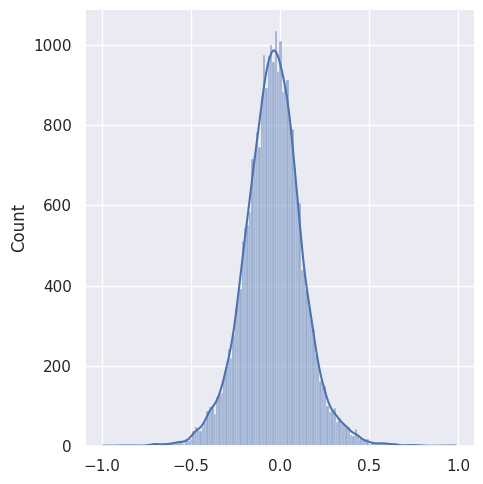

In [33]:
# use seaborn to plot the histogram for the diffs
import seaborn as sns
sns.set_theme()
sns.displot(diffs_in_tp_S, kde=True)
# sns.displot(diffs_in_tp_S, kde=True)